<a href="https://colab.research.google.com/github/JenniferTongco/Face_Mask_Detector/blob/main/Face_Mask_Detector_Tongco%2CJennifer_and_Relator%2C_Jansen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imutils

In [ ]:
# Import necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from zipfile import ZipFile

In [ ]:
dataset_zip = '/content/dataset.zip'

# Extract the zip file to /content/ directory
with ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')
    print('Dataset extracted successfully')

# Path to the extracted dataset folder
dataset_path = '/content/dataset'

Dataset extracted successfully


In [ ]:
# Verify the folder structure
print("Contents of dataset directory:", os.listdir(dataset_path))

Contents of dataset directory: ['without_mask', 'with_mask']


In [ ]:
# Count the number of images in each category
with_mask_files = os.listdir(os.path.join(dataset_path, "with_mask"))
without_mask_files = os.listdir(os.path.join(dataset_path, "without_mask"))

print("Number of 'with_mask' images:", len(with_mask_files))
print("Number of 'without_mask' images:", len(without_mask_files))

Number of 'with_mask' images: 1915
Number of 'without_mask' images: 1918


In [ ]:
CATEGORIES = ["with_mask", "without_mask"]
data = []
labels = []

# Loop through the categories and load images
for category in CATEGORIES:
    category_path = os.path.join(dataset_path, category)  # Full path to each category
    print(f"Loading images from category: {category_path}")
    if os.path.exists(category_path):  # Check if the directory exists
        for img in os.listdir(category_path):  # Loop through images
            img_path = os.path.join(category_path, img)
            image = load_img(img_path, target_size=(224, 224))  # Resize image
            image = img_to_array(image)  # Convert to array
            image = preprocess_input(image)  # Preprocess image for MobileNetV2

            data.append(image)  # Add image data to list
            labels.append(category)  # Add category label to list
    else:
        print(f"Directory {category_path} not found!")

Loading images from category: /content/dataset/with_mask


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loading images from category: /content/dataset/without_mask


In [ ]:
# One-hot encode the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# Convert the data and labels list into a numpy array
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
#  Build the MobileNetV2 model for transfer learning
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Build the head of the model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)  # Two classes: with_mask, without_mask

# Create the full model
model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
	layer.trainable = False


<ipython-input-11-8040d4ba40b2>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
#Compile the model
print("compiling the model...")
INIT_LR = 1e-4  # Initial learning rate
EPOCHS = 20  # Number of epochs to train for
BS = 32  # Batch size

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Train the head of the model
print("training the head...")
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS)


training the head...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - accuracy: 0.7012 - loss: 0.6422 - val_accuracy: 0.9713 - val_loss: 0.1813
Epoch 2/20
 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9062 - loss: 0.2381

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9062 - loss: 0.2381 - val_accuracy: 0.9739 - val_loss: 0.1790
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - accuracy: 0.9666 - loss: 0.1753 - val_accuracy: 0.9739 - val_loss: 0.0945
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9062 - loss: 0.2548 - val_accuracy: 0.9752 - val_loss: 0.0936
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 347ms/step - accuracy: 0.9769 - loss: 0.1081 - val_accuracy: 0.9817 - val_loss: 0.0666
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.1966 - val_accuracy: 0.9804 - val_loss: 0.0663
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 356ms/step - accuracy: 0.9835 - loss: 0.0809 - val_accuracy: 0.9791 - val_loss: 0.0544
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9375 - loss: 0.0960 - val_accuracy: 0.9804 - val_loss: 0.0544
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - accuracy: 0.9817 - loss: 0.0643 - val_accuracy: 0.9844 - val_los

In [ ]:
# Save the trained model
model.save("/content/face_mask_detector.keras")

In [ ]:
#  Evaluate the model
print("Evaluating the model")
predictions = model.predict(X_test, batch_size=32)

# Convert predictions to class labels
predIdxs = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb.classes_))


Evaluating the model
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
Classification Report:
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [ ]:
# Evaluate the model
print("Evaluating the model")
predictions = model.predict(X_test, batch_size=32)

# Convert predictions to class labels
predIdxs = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
report = classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb.classes_, output_dict=True)

# Format the classification report metrics to 4 decimal places
for label, metrics in report.items():
    if label != 'accuracy':  # Accuracy is calculated separately
        print(f"Class: {label}")
        for metric, value in metrics.items():
            if isinstance(value, float):  # Only format float values
                print(f"  {metric.capitalize()}: {value:.4f}")
    else:
        print(f"Accuracy: {report['accuracy']:.4f}")


Evaluating the model
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Classification Report:
Class: with_mask
  Precision: 0.9921
  Recall: 0.9869
  F1-score: 0.9895
  Support: 383.0000
Class: without_mask
  Precision: 0.9870
  Recall: 0.9922
  F1-score: 0.9896
  Support: 384.0000
Accuracy: 0.9896
Class: macro avg
  Precision: 0.9896
  Recall: 0.9896
  F1-score: 0.9896
  Support: 767.0000
Class: weighted avg
  Precision: 0.9896
  Recall: 0.9896
  F1-score: 0.9896
  Support: 767.0000


Confusion Matrix:


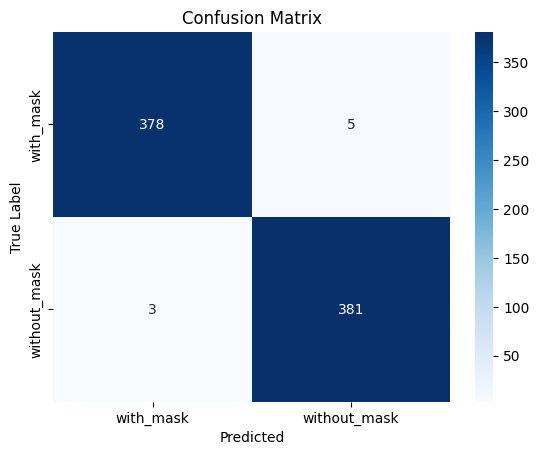

In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(np.argmax(y_test, axis=1), predIdxs)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



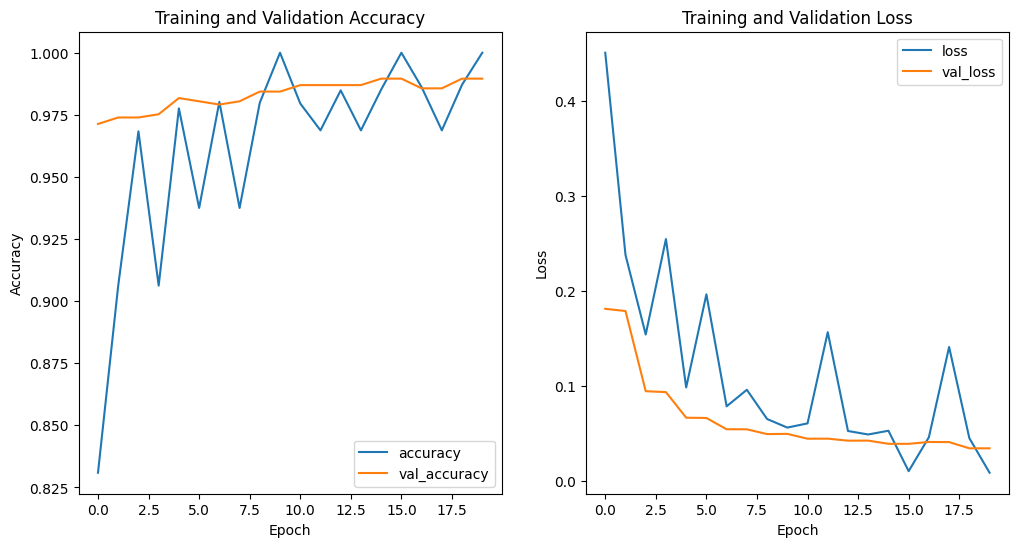

In [ ]:
# Plot the training and validation accuracy/loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'], label='accuracy')
plt.plot(H.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label='loss')
plt.plot(H.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
# F1 Score
f1 = f1_score(y_test.argmax(axis=1), predIdxs, average="weighted")
print(f"F1 score: {f1:.4f}")


F1 score: 0.9896


In [ ]:
# Display training and validation accuracy
print(f"Training accuracy: {H.history['accuracy'][-1]:.4f}")
print(f"Validation accuracy: {H.history['val_accuracy'][-1]:.4f}")

Training accuracy: 1.0000
Validation accuracy: 0.9896
